In [1]:
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

In [2]:


import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Layer, Lambda
from sklearn.model_selection import train_test_split
import os
import imageio
import cv2
import glob2
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import np_utils


Using TensorFlow backend.


In [3]:
import glob

In [4]:
example_image = imageio.imread('example.png')

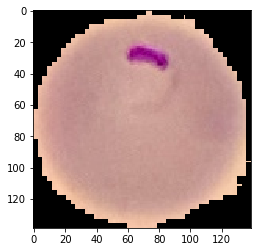

In [5]:
plt.imshow(example_image)

In [6]:
parasitized_cells = os.listdir('C:\\Users\\Thomas\\Malaria Project\\Parasitized\\')
#Importing the data for the parasitized cells

uninfected_cells = os.listdir('C:\\Users\\Thomas\\Malaria Project\\Uninfected')
#importing uninfected cell image data


In [7]:
print(len(parasitized_cells))
print(len(uninfected_cells))
#confirming all the data was put in 

13780
13780


In [8]:
data = []
labels = []

for img in parasitized_cells:
    try:
        img_read = plt.imread('C:\\Users\\Thomas\\Malaria Project\\Parasitized\\' + img)
        img_resize = cv2.resize(img_read, (50,50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)
    except:
        print("Error with Parasitized cell")
        
for img in uninfected_cells:
    try: 
        img_read = plt.imread('C:\\Users\\Thomas\\Malaria Project\\Uninfected\\' + img)
        img_resize = cv2.resize(img_read, (50,50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        print("Error with uninfected cell")


Error with Parasitized cell
Error with uninfected cell


### The "errors" in the above cell
Each folder has a .db file in them which cannot be read by imread.  This means that one error per folder is exactly what we are looking for

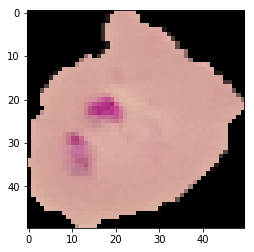

In [9]:
#Checking to see if the images were imported
plt.imshow(data[3])
plt.show()

In [10]:
image_data = np.array(data)
labels = np.array(labels)

In [11]:
#Processing the data for modeling
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

In [12]:
#Sanity check on labeling
import collections

labels
collections.Counter(labels)

Counter({1: 13779, 0: 13779})

In [13]:
#Train test split 
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size = .2, random_state = 42)

In [14]:
y_train = np_utils.to_categorical(y_train, num_classes = 2)

y_test  = np_utils.to_categorical(y_test, num_classes = 2)

In [15]:
print(f"Shape of training image data : {x_train.shape}")
print(f"Shape of testing image data : {x_test.shape}")
print(f"Shape of training labels : {y_train.shape}")
print(f"Shape of testing labels: {y_test.shape}")

Shape of training image data : (22046, 50, 50, 3)
Shape of testing image data : (5512, 50, 50, 3)
Shape of training labels : (22046, 2)
Shape of testing labels: (5512, 2)


In [16]:


import keras
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K

from keras import optimizers



### Model Creation

In [17]:
def CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
   
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [18]:
height = 50
width = 50
classes = 2
channels = 3
model = CNNbuild(height = height, width = width, classes = classes, 
                channels = channels)
model.summary()








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
____________________

In [19]:
import keras_metrics
import tensorflow as tf

In [20]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['acc',f1_m,precision_m, recall_m])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
keras.backend.get_session().run(tf.global_variables_initializer())

In [22]:
first_model = model.fit(x_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
22046/22046 [==============================] - 11s 489us/step - loss: 0.5465 - acc: 0.7584 - f1_m: 0.7584 - precision_m: 0.7584 - recall_m: 0.7584
Epoch 2/20
22046/22046 [==============================] - 8s 378us/step - loss: 0.2327 - acc: 0.9162 - f1_m: 0.9162 - precision_m: 0.9162 - recall_m: 0.9162
Epoch 3/20
22046/22046 [==============================] - 9s 423us/step - loss: 0.1980 - acc: 0.9334 - f1_m: 0.9334 - precision_m: 0.9334 - recall_m: 0.9334 8s - loss: 0.2193 - acc: 0.9276 - - ETA: 4s - loss: 0.2009
Epoch 4/20
22046/22046 [==============================] - 8s 379us/step - loss: 0.1879 - acc: 0.9382 - f1_m: 0.9382 - precision_m: 0.9382 - recall_m: 0.9382
Epoch 5/20
22046/22046 [==============================] - 9s 395us/step - loss: 0.1833 - acc: 0.9408 - f1_m: 0.9408 - precision_m: 0.9408 - recall_m: 0.9408 4s - loss: 0.1803 
Epoch 6/20
22046/22046 [==============================] - 9s 392us/step - loss: 0.1759 - acc: 0.9424 - f1_m: 0.9424 - precision_m: 0.942

In [23]:
predictions = model.evaluate(x_test, y_test)


print(f'LOSS : {predictions[0]}')
print(f'ACCURACY : {predictions[1]}')

5512/5512 [==============================] - 1s 148us/step
LOSS : 0.13348918310832908
ACCURACY : 0.9582728592162555


In [24]:
y_pred = model.predict(x_test)
#y_pred_tensor = tf.convert_to_tensor(y_pred, np.float32)
#y_test_tensor = tf.convert_to_tensor(y_test, np.float32)
sess = tf.InteractiveSession()



In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

y_pred2=np.argmax(y_pred, axis=1)
y_test2=np.argmax(y_test, axis=1)
confusion_matrix(y_test2, y_pred2)

array([[2653,   60],
       [ 170, 2629]], dtype=int64)

In [26]:
recall_score(y_test2, y_pred2)

0.9392640228653091

In [27]:
print("Recall score of the model: " +str(recall_score(y_test2, y_pred2)))

Recall score of the model: 0.9392640228653091


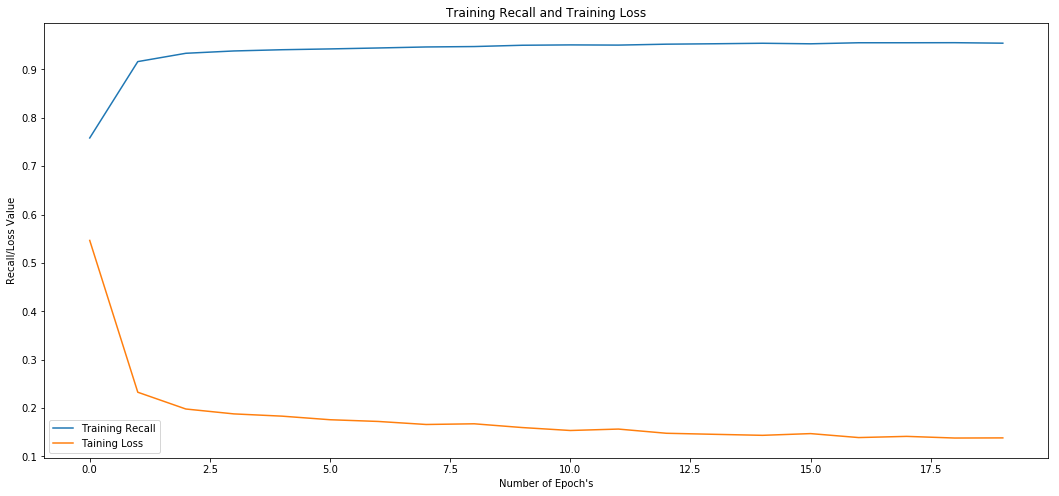

In [28]:
plt.figure(figsize = (18,8))
plt.plot(range(20), first_model.history['acc'], label = 'Training Recall')
plt.plot(range(20), first_model.history['loss'], label = 'Taining Loss')

plt.xlabel("Number of Epoch's")
plt.ylabel('Recall/Loss Value')
plt.title('Training Recall and Training Loss')
plt.legend(loc = "best")
#graphing how the accuracy and loss change over the epochs

In [29]:
from keras.preprocessing.image import ImageDataGenerator

In [30]:
train_datagen = ImageDataGenerator(#rescale = 1/255.,
                                  horizontal_flip = True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  fill_mode = 'nearest',
                                  zoom_range = 0.3,
                                  rotation_range = 30)
val_datagen = ImageDataGenerator() #rescale = 1/255.)

train_generator = train_datagen.flow(x_train, y_train, batch_size = 64, shuffle = True)
val_generator = val_datagen.flow(x_test, y_test, batch_size = 64, shuffle = False)

In [31]:
augmented_model = CNNbuild(height = height, width = width, classes = classes, channels = channels)

In [32]:

aug_optim = optimizers.Adam(lr = 0.001, decay = 0.001 / 64)
augmented_model.compile(loss = 'categorical_crossentropy', 
                        optimizer = aug_optim, 
                        metrics = ['acc',f1_m,precision_m, recall_m])

In [33]:
history_augmented_model = augmented_model.fit_generator(train_generator,
                                 steps_per_epoch = len(x_train) // 64,
                                epochs = 20)

Epoch 1/20
344/344 [==============================] - 17s 48ms/step - loss: 0.7452 - acc: 0.6509 - f1_m: 0.6509 - precision_m: 0.6509 - recall_m: 0.6509
Epoch 2/20
344/344 [==============================] - 16s 47ms/step - loss: 0.4096 - acc: 0.8213 - f1_m: 0.8213 - precision_m: 0.8213 - recall_m: 0.8213 5s - loss: 0.4306 - acc: 
Epoch 3/20
344/344 [==============================] - 16s 47ms/step - loss: 0.3396 - acc: 0.8622 - f1_m: 0.8622 - precision_m: 0.8622 - recall_m: 0.8622
Epoch 4/20
344/344 [==============================] - 16s 47ms/step - loss: 0.3124 - acc: 0.8781 - f1_m: 0.8781 - precision_m: 0.8781 - recall_m: 0.8781
Epoch 5/20
344/344 [==============================] - 16s 48ms/step - loss: 0.2980 - acc: 0.8880 - f1_m: 0.8880 - precision_m: 0.8880 - recall_m: 0.8880 6s - los
Epoch 6/20
344/344 [==============================] - 17s 48ms/step - loss: 0.2916 - acc: 0.8912 - f1_m: 0.8912 - precision_m: 0.8912 - recall_m: 0.8912
Epoch 7/20
344/344 [===========================

In [34]:
prediction_2 = augmented_model.evaluate_generator(val_generator, steps = 5)

In [35]:


print(f'LOSS : {prediction_2[0]}')
print(f'ACCURACY : {prediction_2[1]}')

LOSS : 0.13045202940702438
ACCURACY : 0.9625


In [36]:
print(prediction_2)

[0.13045202940702438, 0.9625, 0.9624999403953552, 0.9625, 0.9625]


In [37]:
#y_pred_augmented = augmented_model.predict_generator(val_generator, steps = 5)


config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 31} )
sess = tf.Session(config=config) 
sess.as_default()

y_test_tensor = tf.convert_to_tensor(y_test, np.float32)

y_pred_augmented = augmented_model.predict(x_test)
y_pred_augmented_tensor = tf.convert_to_tensor(y_pred_augmented, np.float32)


In [38]:
from sklearn.metrics import confusion_matrix
y_pred2_augmented=np.argmax(y_pred_augmented, axis=1)
y_test2=np.argmax(y_test, axis=1)
augmented_matrix = confusion_matrix(y_test2, y_pred2_augmented)
print(augmented_matrix)

[[2600  113]
 [ 115 2684]]


In [39]:
recall_score(y_test2, y_pred2_augmented)

0.9589138978206503

### Second model
The second model will look at what happens to our metrics if we remove one of the layers in the CNN.  The model with one less layer will be CNNbuild2.

In [40]:
def CNNbuild2(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
   
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [41]:
height = 50
width = 50
classes = 2
channels = 3
model2 = CNNbuild(height = height, width = width, classes = classes, 
                channels = channels)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 11, 11, 32)        128       
__________

In [42]:
model2.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['acc',f1_m,precision_m, recall_m])

In [43]:
second_model = model2.fit(x_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
22046/22046 [==============================] - 11s 502us/step - loss: 0.5997 - acc: 0.7331 - f1_m: 0.7331 - precision_m: 0.7331 - recall_m: 0.73312s - loss: 0.6871 - acc: 0.6901 - f1_m: 0.6
Epoch 2/20
22046/22046 [==============================] - 10s 437us/step - loss: 0.2407 - acc: 0.9122 - f1_m: 0.9122 - precision_m: 0.9122 - recall_m: 0.9122
Epoch 3/20
22046/22046 [==============================] - 9s 425us/step - loss: 0.2040 - acc: 0.9314 - f1_m: 0.9314 - precision_m: 0.9314 - recall_m: 0.9314
Epoch 4/20
22046/22046 [==============================] - 10s 431us/step - loss: 0.1860 - acc: 0.9382 - f1_m: 0.9382 - precision_m: 0.9382 - recall_m: 0.9382
Epoch 5/20
22046/22046 [==============================] - 9s 424us/step - loss: 0.1797 - acc: 0.9438 - f1_m: 0.9438 - precision_m: 0.9438 - recall_m: 0.9438
Epoch 6/20
22046/22046 [==============================] - 10s 432us/step - loss: 0.1780 - acc: 0.9423 - f1_m: 0.9423 - precision_m: 0.9423 - recall_m: 0.9423
Epoch 7/20


In [45]:
predictions2 = model2.evaluate(x_test, y_test)


print(f'LOSS : {predictions2[0]}')
print(f'ACCURACY : {predictions2[1]}')

5512/5512 [==============================] - 1s 168us/step
LOSS : 0.13270007179852666
ACCURACY : 0.9613570391872278


In [47]:
model2_y_pred = model2.predict(x_test)
model2_y_pred2=np.argmax(model2_y_pred, axis=1)
#y_test2=np.argmax(y_test, axis=1)
confusion_matrix(y_test2, model2_y_pred2)

array([[2659,   54],
       [ 159, 2640]], dtype=int64)

In [48]:
print("Recall score of the model: " +str(recall_score(y_test2, model2_y_pred2)))

Recall score of the model: 0.9431939978563773


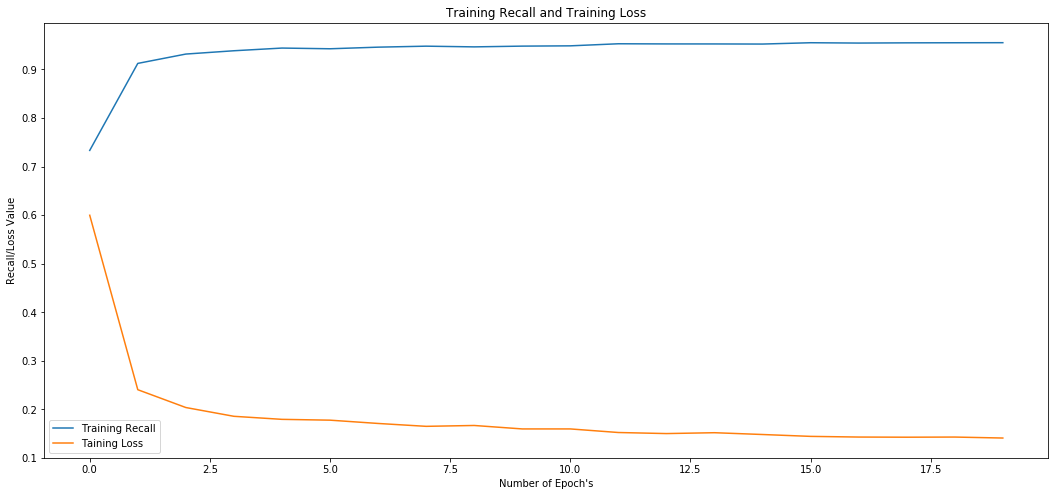

In [49]:
plt.figure(figsize = (18,8))
plt.plot(range(20), second_model.history['acc'], label = 'Training Recall')
plt.plot(range(20), second_model.history['loss'], label = 'Taining Loss')

plt.xlabel("Number of Epoch's")
plt.ylabel('Recall/Loss Value')
plt.title('Training Recall and Training Loss')
plt.legend(loc = "best")
#graphing how the accuracy and loss change over the epochs

In [50]:
augmented_model2 = CNNbuild2(height = height, width = width, classes = classes, channels = channels)
augmented_model2.compile(loss = 'categorical_crossentropy', 
                        optimizer = aug_optim, 
                        metrics = ['acc',f1_m,precision_m, recall_m])

In [51]:
history_augmented_model = augmented_model2.fit_generator(train_generator,
                                 steps_per_epoch = len(x_train) // 64,
                                epochs = 20)

Epoch 1/20
344/344 [==============================] - 17s 49ms/step - loss: 0.7259 - acc: 0.6230 - f1_m: 0.6230 - precision_m: 0.6230 - recall_m: 0.6230
Epoch 2/20
344/344 [==============================] - 17s 49ms/step - loss: 0.4062 - acc: 0.8262 - f1_m: 0.8262 - precision_m: 0.8262 - recall_m: 0.8262
Epoch 3/20
344/344 [==============================] - 18s 52ms/step - loss: 0.3264 - acc: 0.8692 - f1_m: 0.8692 - precision_m: 0.8692 - recall_m: 0.8692 12s 
Epoch 4/20
344/344 [==============================] - 18s 54ms/step - loss: 0.3050 - acc: 0.8820 - f1_m: 0.8820 - precision_m: 0.8820 - recall_m: 0.8820
Epoch 5/20
344/344 [==============================] - 17s 48ms/step - loss: 0.2915 - acc: 0.8905 - f1_m: 0.8905 - precision_m: 0.8905 - recall_m: 0.8905
Epoch 6/20
344/344 [==============================] - 16s 47ms/step - loss: 0.2860 - acc: 0.8936 - f1_m: 0.8936 - precision_m: 0.8936 - recall_m: 0.8936 6s - loss: 0.2896 - acc: 0.8943 - f1_m: 0.8943 - precision_m: 0.8943 - re - E

In [52]:
augmented_prediction_2 = augmented_model2.evaluate_generator(val_generator, steps = 5)

In [54]:
y_pred_augmented2 = augmented_model2.predict(x_test)
y_pred_augmented_tensor2 = tf.convert_to_tensor(y_pred_augmented2, np.float32)

y_pred2_augmented=np.argmax(y_pred_augmented2, axis=1)
y_test2=np.argmax(y_test, axis=1)
model2_augmented_matrix = confusion_matrix(y_test2, y_pred2_augmented)
print(model2_augmented_matrix)

[[2659   54]
 [ 191 2608]]


In [55]:
print("Recall score of the model: " +str(recall_score(y_test2, y_pred2_augmented)))

Recall score of the model: 0.9317613433369061


## Model 3
For model 3 we are going to use only the accuracy and recall metrics when compiling the model. 

In [56]:
model3 = CNNbuild(height = height, width = width, classes = classes, 
                channels = channels)
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
dropout_20 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 11, 11, 32)        128       
__________

In [57]:
#Compiling model 3
model3.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['acc', recall_m])

In [58]:
third_model = model3.fit(x_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
22046/22046 [==============================] - 10s 463us/step - loss: 0.6601 - acc: 0.6948 - recall_m: 0.6948
Epoch 2/20
22046/22046 [==============================] - 9s 423us/step - loss: 0.2654 - acc: 0.8994 - recall_m: 0.8994
Epoch 3/20
22046/22046 [==============================] - 9s 425us/step - loss: 0.2071 - acc: 0.9274 - recall_m: 0.9274
Epoch 4/20
22046/22046 [==============================] - 10s 460us/step - loss: 0.1864 - acc: 0.9380 - recall_m: 0.9380
Epoch 5/20
22046/22046 [==============================] - 10s 468us/step - loss: 0.1788 - acc: 0.9405 - recall_m: 0.9405
Epoch 6/20
22046/22046 [==============================] - 11s 490us/step - loss: 0.1809 - acc: 0.9402 - recall_m: 0.9402s - loss: 0.1
Epoch 7/20
22046/22046 [==============================] - 10s 446us/step - loss: 0.1709 - acc: 0.9441 - recall_m: 0.9441
Epoch 8/20
22046/22046 [==============================] - 10s 454us/step - loss: 0.1690 - acc: 0.9458 - recall_m: 0.9458
Epoch 9/20
22046/2204

In [59]:
predictions3 = model3.evaluate(x_test, y_test)

print(f'LOSS : {predictions3[0]}')
print(f'ACCURACY : {predictions3[1]}')

5512/5512 [==============================] - 1s 190us/step
LOSS : 0.12121711635126776
ACCURACY : 0.9620827285921626


In [60]:
model3_y_pred = model3.predict(x_test)
model3_y_pred2=np.argmax(model3_y_pred, axis=1)
#y_test2=np.argmax(y_test, axis=1)
confusion_matrix(y_test2, model3_y_pred2)

array([[2652,   61],
       [ 148, 2651]], dtype=int64)

In [61]:
print("Recall score of the model: " +str(recall_score(y_test2, model3_y_pred2)))

Recall score of the model: 0.9471239728474455


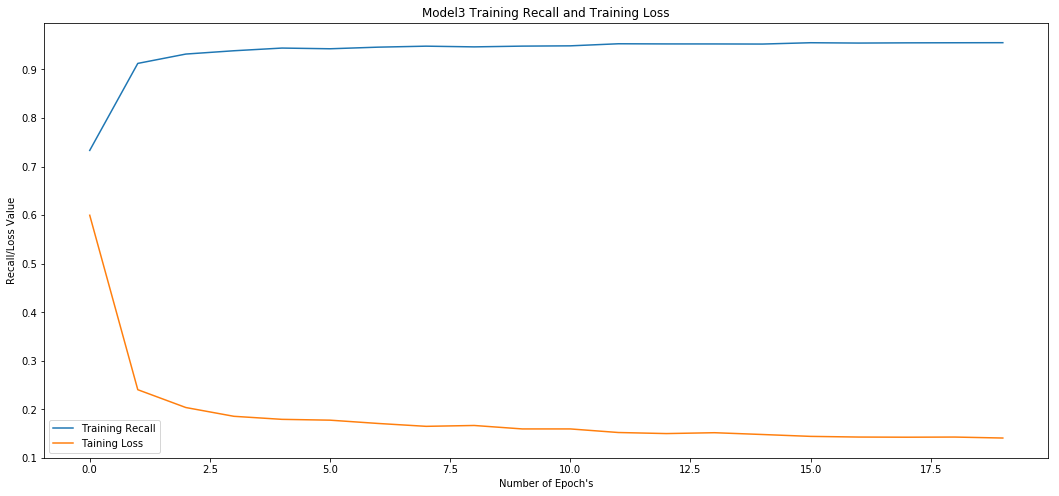

In [62]:
plt.figure(figsize = (18,8))
plt.plot(range(20), second_model.history['acc'], label = 'Training Recall')
plt.plot(range(20), second_model.history['loss'], label = 'Taining Loss')

plt.xlabel("Number of Epoch's")
plt.ylabel('Recall/Loss Value')
plt.title('Model3 Training Recall and Training Loss')
plt.legend(loc = "best")

In [63]:
augmented_model3 = CNNbuild(height = height, width = width, classes = classes, channels = channels)

augmented_model3.compile(loss = 'categorical_crossentropy', 
                        optimizer = aug_optim, 
                        metrics = ['acc', recall_m])

In [64]:
history_augmented_model3 = augmented_model3.fit_generator(train_generator,
                                 steps_per_epoch = len(x_train) // 64,
                                epochs = 20)

Epoch 1/20
344/344 [==============================] - 17s 51ms/step - loss: 0.7490 - acc: 0.5947 - recall_m: 0.5947
Epoch 2/20
344/344 [==============================] - 17s 49ms/step - loss: 0.5793 - acc: 0.6957 - recall_m: 0.6957
Epoch 3/20
344/344 [==============================] - 16s 47ms/step - loss: 0.3885 - acc: 0.8316 - recall_m: 0.8316
Epoch 4/20
344/344 [==============================] - 17s 48ms/step - loss: 0.3328 - acc: 0.8685 - recall_m: 0.8685
Epoch 5/20
344/344 [==============================] - 16s 47ms/step - loss: 0.3126 - acc: 0.8774 - recall_m: 0.87741s - loss: 0.3122 - acc: 0
Epoch 6/20
344/344 [==============================] - 17s 48ms/step - loss: 0.3024 - acc: 0.8838 - recall_m: 0.8838
Epoch 7/20
344/344 [==============================] - 16s 48ms/step - loss: 0.2975 - acc: 0.8853 - recall_m: 0.88530s - loss: 0.2967 - acc: 0.8855 - 
Epoch 8/20
344/344 [==============================] - 16s 45ms/step - loss: 0.2875 - acc: 0.8913 - recall_m: 0.8913
Epoch 9/20
3

In [65]:
y_pred_augmented3 = augmented_model3.predict(x_test)
y_pred_augmented_tensor3 = tf.convert_to_tensor(y_pred_augmented3, np.float32)

y_pred3_augmented=np.argmax(y_pred_augmented3, axis=1)
y_test3=np.argmax(y_test, axis=1)
model3_augmented_matrix = confusion_matrix(y_test2, y_pred3_augmented)
print(model3_augmented_matrix)

[[2639   74]
 [ 147 2652]]


In [67]:
print("Recall score of the model: " +str(recall_score(y_test2, y_pred3_augmented)))

Recall score of the model: 0.947481243301179


### Model 4:  Rescaled augmented images
This model will focus on what happens if we try image rescaling.

For this one we are going to skip the non-augmented version and jump staight into the augmented network. 

In [72]:
rescaled_train_datagen = ImageDataGenerator(rescale = 1/255.,
                                  horizontal_flip = True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  fill_mode = 'nearest',
                                  zoom_range = 0.3,
                                  rotation_range = 30)
rescaled_val_datagen = ImageDataGenerator(rescale = 1/255.)

rescaled_train_generator = train_datagen.flow(x_train, y_train, batch_size = 64, shuffle = True)
#val_generator = val_datagen.flow(x_test, y_test, batch_size = 64, shuffle = False)

In [69]:
rescaled_augmented_model = CNNbuild(height = height, width = width, classes = classes, channels = channels)

In [70]:
rescaled_augmented_model.compile(loss = 'categorical_crossentropy', 
                        optimizer = aug_optim, 
                        metrics = ['acc',f1_m,precision_m, recall_m])

In [73]:
rescaled_history_augmented_model = rescaled_augmented_model.fit_generator(rescaled_train_generator,
                                 steps_per_epoch = len(x_train) // 64,
                                epochs = 20)

Epoch 1/20
344/344 [==============================] - 18s 52ms/step - loss: 0.6570 - acc: 0.6815 - f1_m: 0.6815 - precision_m: 0.6815 - recall_m: 0.6815
Epoch 2/20
344/344 [==============================] - 18s 52ms/step - loss: 0.3899 - acc: 0.8364 - f1_m: 0.8364 - precision_m: 0.8364 - recall_m: 0.8364
Epoch 3/20
344/344 [==============================] - 17s 50ms/step - loss: 0.3443 - acc: 0.8625 - f1_m: 0.8625 - precision_m: 0.8625 - recall_m: 0.8625 1s - loss: 0.3460 - acc: 0.8621 - f1_m: 0.8621 - precision_m: 0.862
Epoch 4/20
344/344 [==============================] - 16s 48ms/step - loss: 0.3119 - acc: 0.8801 - f1_m: 0.8801 - precision_m: 0.8801 - recall_m: 0.8801
Epoch 5/20
344/344 [==============================] - 17s 48ms/step - loss: 0.3035 - acc: 0.8851 - f1_m: 0.8851 - precision_m: 0.8851 - recall_m: 0.8851
Epoch 6/20
344/344 [==============================] - 16s 48ms/step - loss: 0.2950 - acc: 0.8902 - f1_m: 0.8902 - precision_m: 0.8902 - recall_m: 0.8902
Epoch 7/20
344

In [74]:
rescaled_prediction = rescaled_augmented_model.evaluate_generator(val_generator, steps = 5)

In [75]:
print(f'LOSS : {rescaled_prediction[0]}')
print(f'ACCURACY : {rescaled_prediction[1]}')

LOSS : 0.18568661212921142
ACCURACY : 0.946875


In [76]:
rescaled_y_pred_augmented = rescaled_augmented_model.predict(x_test)
rescaled_y_pred_augmented_tensor = tf.convert_to_tensor(rescaled_y_pred_augmented, np.float32)

rescaled_y_pred_augmented=np.argmax(rescaled_y_pred_augmented, axis=1)
#y_test2=np.argmax(y_test, axis=1)
rescaled_augmented_matrix = confusion_matrix(y_test2, rescaled_y_pred_augmented)
print(rescaled_augmented_matrix)


[[2598  115]
 [ 120 2679]]


In [77]:
print("Recall score of the model: " +str(recall_score(y_test2, rescaled_y_pred_augmented)))

Recall score of the model: 0.9571275455519829


### Model 5: Sigmoid activation function
For this we are going to use a sigmoid function instead of relu. 

In [82]:
def Sigmoid_CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'sigmoid', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'sigmoid'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'sigmoid'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
   
    model.add(Conv2D(32, (3,3), activation = 'sigmoid'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(512, activation = 'sigmoid'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [83]:
model5 = Sigmoid_CNNbuild(height = height, width = width, classes = classes, 
                channels = channels)
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
dropout_40 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 11, 11, 32)        128       
__________

In [84]:

model5.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['acc',f1_m,precision_m, recall_m])

In [85]:
fifth_model = model5.fit(x_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
22046/22046 [==============================] - 13s 600us/step - loss: 0.6353 - acc: 0.7096 - f1_m: 0.7096 - precision_m: 0.7096 - recall_m: 0.70960s - loss: 0.6420 - acc: 0.7058 - f1_m: 0.7058 - precision_m: 0.7058 - recall_m
Epoch 2/20
22046/22046 [==============================] - 11s 514us/step - loss: 0.3280 - acc: 0.8699 - f1_m: 0.8699 - precision_m: 0.8699 - recall_m: 0.86996s - loss: 0.3737 - acc: 0.8459 - f1 - ETA: 3s - loss: 0.3511 - acc: 0.8575 - f
Epoch 3/20
22046/22046 [==============================] - 11s 492us/step - loss: 0.2227 - acc: 0.9218 - f1_m: 0.9218 - precision_m: 0.9218 - recall_m: 0.9218
Epoch 4/20
22046/22046 [==============================] - 11s 519us/step - loss: 0.1956 - acc: 0.9355 - f1_m: 0.9355 - precision_m: 0.9355 - recall_m: 0.9355 - ETA
Epoch 5/20
22046/22046 [==============================] - 14s 614us/step - loss: 0.1850 - acc: 0.9397 - f1_m: 0.9397 - precision_m: 0.9397 - recall_m: 0.9397
Epoch 6/20
22046/22046 [======================

In [86]:
predictions5 = model5.evaluate(x_test, y_test)

print(f'LOSS : {predictions5[0]}')
print(f'ACCURACY : {predictions5[1]}')

5512/5512 [==============================] - 1s 251us/step
LOSS : 0.1283198522595778
ACCURACY : 0.9595428156748912


In [87]:
model5_y_pred = model5.predict(x_test)
model5_y_pred2=np.argmax(model5_y_pred, axis=1)
#y_test2=np.argmax(y_test, axis=1)
confusion_matrix(y_test2, model5_y_pred2)

array([[2656,   57],
       [ 166, 2633]], dtype=int64)

In [88]:
print("Recall score of the model: " +str(recall_score(y_test2, model5_y_pred2)))

Recall score of the model: 0.9406931046802429


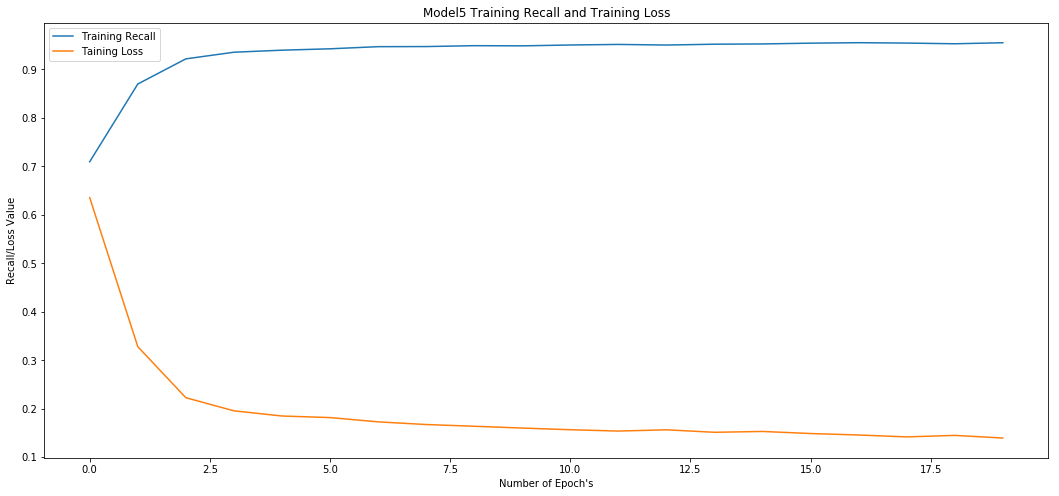

In [89]:
plt.figure(figsize = (18,8))
plt.plot(range(20), fifth_model.history['acc'], label = 'Training Recall')
plt.plot(range(20), fifth_model.history['loss'], label = 'Taining Loss')

plt.xlabel("Number of Epoch's")
plt.ylabel('Recall/Loss Value')
plt.title('Model5 Training Recall and Training Loss')
plt.legend(loc = "best")

In [90]:
augmented_model5 = Sigmoid_CNNbuild(height = height, width = width, classes = classes, channels = channels)

In [91]:
augmented_model5.compile(loss = 'categorical_crossentropy', 
                        optimizer = aug_optim, 
                        metrics = ['acc',f1_m,precision_m, recall_m])

In [92]:
history_augmented_model5 = augmented_model5.fit_generator(train_generator,
                                 steps_per_epoch = len(x_train) // 64,
                                epochs = 20)

Epoch 1/20
344/344 [==============================] - 18s 53ms/step - loss: 0.6903 - acc: 0.6518 - f1_m: 0.6518 - precision_m: 0.6518 - recall_m: 0.6518 2s - loss: 0.7090 - acc: 0.6419 - f1_m: 0.6419 - prec
Epoch 2/20
344/344 [==============================] - 17s 50ms/step - loss: 0.5259 - acc: 0.7565 - f1_m: 0.7565 - precision_m: 0.7565 - recall_m: 0.7565
Epoch 3/20
344/344 [==============================] - 16s 48ms/step - loss: 0.4498 - acc: 0.8050 - f1_m: 0.8050 - precision_m: 0.8050 - recall_m: 0.8050
Epoch 4/20
344/344 [==============================] - 16s 48ms/step - loss: 0.3890 - acc: 0.8414 - f1_m: 0.8414 - precision_m: 0.8414 - recall_m: 0.8414
Epoch 5/20
344/344 [==============================] - 16s 48ms/step - loss: 0.3465 - acc: 0.8620 - f1_m: 0.8620 - precision_m: 0.8620 - recall_m: 0.8620
Epoch 6/20
344/344 [==============================] - 17s 49ms/step - loss: 0.3194 - acc: 0.8779 - f1_m: 0.8779 - precision_m: 0.8779 - recall_m: 0.8779
Epoch 7/20
344/344 [========

In [93]:
prediction_5 = augmented_model5.evaluate_generator(val_generator, steps = 5)

In [94]:
print(f'LOSS : {prediction_5[0]}')
print(f'ACCURACY : {prediction_5[1]}')

LOSS : 0.20190924704074859
ACCURACY : 0.93125


In [95]:
y_pred_augmented5 = augmented_model5.predict(x_test)
y_pred_augmented5_tensor = tf.convert_to_tensor(y_pred_augmented5, np.float32)


In [96]:
y_pred5_augmented=np.argmax(y_pred_augmented5, axis=1)
#y_test2=np.argmax(y_test, axis=1)
augmented_matrix5 = confusion_matrix(y_test2, y_pred5_augmented)
print(augmented_matrix5)

[[2655   58]
 [ 228 2571]]


In [97]:
print("Recall score of the model: " +str(recall_score(y_test2, y_pred5_augmented)))

Recall score of the model: 0.9185423365487674
